# Lecture 7: Using Netket to find the ground-state of the J1-J2 model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PhilipVinc/ComputationalQuantumPhysics/blob/main/Notebooks/5-VMC/Lecture%207.ipynb)

This time we will use NetKet to obtain the ground state of the J1-J2 model in one-dimension with periodic boundary conditions, using a Neural Network variational wave-function. 
The Hamiltonian of the model is given by:

$$ H = J_{1}\sum_{\langle i,j\rangle } \vec{\sigma}_{i} \cdot \vec{\sigma}_{j} +J_{2}  \sum_{\langle\langle i,j\rangle\rangle } \vec{\sigma}_{i} \cdot \vec{\sigma}_{j} $$

where the first sum is over nearest neighbors and the second is over next-nearest neigboors.
Consider taking $$J_1=1$$ and vary $$J_2\in[0,1]$$

We will work on the 4x4 systm size to compare against Exact Diagonalisation. If you feel adventourous you can try to approach 6x6 later.

# Initial experiment:
- Initialy try to change the number of samples, chains and learning rate to understand how they affect convergence. 
- Compare Stochastic Reconfiguration (nk.driver.VMC_SR) vs standard gradient descent (nk.driver.VMC). Change learning rate and diag shift.
- Once you feel you understand those things, move on to the next points.

# Important points:
- We work in the subsector of 0-magnetization, so you set `nk.hilbert.Spin(s=0.5, total_sz=0.0, N=g.n_nodes)``
- The MC sampling must remain in this subsector, so we use the exchange sampling rule `nk.sampler.MetropolisExchange()` with a given graph.
- When doing the optimization, you should play with:
 - network size/number of parameters
 - `VMC_SR(..., diag_shift)` parameter and the learning rate of sgd.
 - number of samples.

## Objectives:
- Compute the ground-state using VMC for the points $J_2=[0.2, 0.3, 0.5, 0.7, 0.8]$ and for each point:
    - Make sure you are relatively well converged in terms of energy. Make sure you look at the statistical error of the energy.
    - Try different NN architectures. Things you can try to use:
        - A jastrow ansatz (nk.models.Jastrow)
        - Deep networks (more than 1 Dense layer)
        - a convolutional layer instead of a dense layer
        - if you are courageous, a small ViT transformer
    - Compute during optimization and at convergence the spin structure factor (See below)



# To speed up the claculation try to:
- increase the number of chains `MetropolisExchange(n_chains=16)` . Default is 16, sometimes it's faster with more
- Reduce the thermalization samples discarded `nk.vqs.MCState(n_discard_per_chain=0)`. Default is much larger andsometimes wasteful.

In [2]:
# ensure we run on the CPU
import os

os.environ["JAX_PLATFORM_NAME"] = "cpu"

# Import netket library
import netket as nk

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

/Users/filippo.vicentini/Nextcloud/Teaching/CompQuantumPhys-2025/Notebooks/5-VMC/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


∣NK⟩ Tip: If timeit=True signals high \% spent sampling n_discarded, consider lowering it.

## 1) Defining a Custom Hamiltonian

The first thing to do is to define the graph (lattice) on which to specify the Hamiltonian. Here we would like to build a one-dimensional graph with both nearest and next nearest neighbour bonds.

In [3]:
# Couplings J1 and J2
J = [1, 0.2]
L = 4

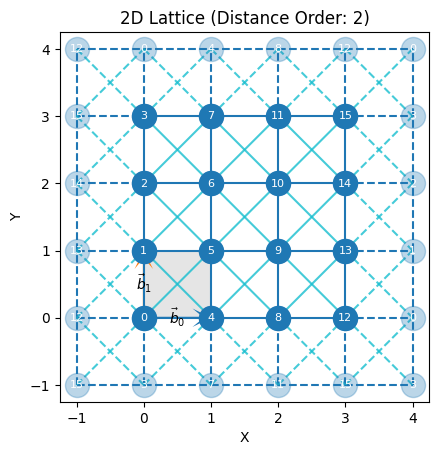

<Axes: title={'center': '2D Lattice (Distance Order: 2)'}, xlabel='X', ylabel='Y'>

In [ ]:
lattice = nk.graph.Square(L, max_neighbor_order=2)
lattice.draw(distance_order=2)

We specify a different ``color`` for each type of bond so as to define a different operator for each of them.
Next, we define the relevant bond operators.

In [11]:
# Spin based Hilbert Space
hi = nk.hilbert.Spin(s=0.5, total_sz=0.0, N=lattice.n_nodes)

# Heisenberg with coupling J=1.0 for nearest neighbors
# and J=0.5 for next-nearest neighbors
H = nk.operator.Heisenberg(hilbert=hi, graph=lattice, J=[1.0, 0.2])

Note that we impose here the total magnetization to be zero (it turns out to be the correct magnetization for the ground-state). As an exercise, check that the energy of the lowest state in other magnetization sectors is larger.

Next, we define the custom graph Hamiltonian using the ``nk.operator.GraphOperator`` class, by providing the hilbert space ``hi``, the bond operators ``bondops=bond_operator`` and the corresponding bond color ``bondops_colors=bond_color``. The information about the graph (bonds and bond colors) are contained within the ``nk.hilbert.Spin`` object ``hi``.

## 2) Defining the Machine

For this tutorial, we shall use the most common type of neural network: fully connected feedforward neural network ``nk.machine.FFNN``. Other types of neural networks available will be discussed in other tutorials.

In [13]:
import netket.nn as nknn
import flax.linen as nn

import jax.numpy as jnp


class FFNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(
            features=2 * x.shape[-1],
            use_bias=True,
            param_dtype=np.complex128,
            kernel_init=nn.initializers.normal(stddev=0.01),
            bias_init=nn.initializers.normal(stddev=0.01),
        )(x)
        x = nknn.log_cosh(x)
        x = jnp.sum(x, axis=-1)
        return x


model = FFNN()

## 3) Variational Monte Carlo Optimisation

We have now set up our model (Hamiltonian, Graph, Hilbert Space) and can proceed to optimise the variational ansatz we chose, namely the ``ffnn`` machine.

To setup the variational Monte Carlo optimisation tool, we have to provide a sampler ``nk.sampler`` and an optimizer ``nk.optimizer``.

In [14]:
# We shall use an exchange Sampler which preserves the global magnetization (as this is a conserved quantity in the model)
sa = nk.sampler.MetropolisExchange(hilbert=hi, graph=lattice, d_max=2)

# Construct the variational state
vs = nk.vqs.MCState(sa, model, n_samples=1008)

# We choose a basic, albeit important, Optimizer: the Stochastic Gradient Descent
opt = nk.optimizer.Sgd(learning_rate=0.01)

# We can then specify a Variational Monte Carlo object, using the Hamiltonian, sampler and optimizers chosen.
# Note that we also specify the method to learn the parameters of the wave-function: here we choose the efficient
# Stochastic reconfiguration (Sr), here in an iterative setup
gs = nk.driver.VMC_SR(hamiltonian=H, optimizer=opt, variational_state=vs, diag_shift=0.01)

/var/folders/b_/dvph1c6569155bspz2m2sml40000gp/T/ipykernel_3880/3501355536.py:17: DeprecationWarning: netket.nn.log_cosh is deprecated: use netket.nn.activation.log_cosh
  x = nknn.log_cosh(x)


Automatic SR implementation choice:  QGT


## 4) Measuring Observables

Before running the optimization, it can be helpful to add some observables to keep track off during the optimization. For our purpose, let us measure the antiferromagnetic structure factor, defined as:

$$ \frac{1}{L} \sum_{ij} \langle \hat{\sigma}_{i}^z \cdot \hat{\sigma}_{j}^z\rangle e^{i\pi(i-j)}$$.

In [16]:
# We need to specify the local operators as a matrix acting on a local Hilbert space
sf = []
sites = []
structure_factor = nk.operator.LocalOperator(hi, dtype=complex)
for i in range(0, L):
    for j in range(0, L):
        structure_factor += (
            (nk.operator.spin.sigmaz(hi, i) @ nk.operator.spin.sigmaz(hi, j))
            * ((-1) ** (i - j))
            / L
        )

Once again, notice that we had to multiply the exchange operator (matrix) by some factor. This is to account for the Marshall basis rotation we made in our model.

We can now optimize our variational ansatz. The optimization data for each iteration will be stored in a log file, which contains the following information:
1. Mean, variance and uncertainty in the Energy $ \langle \hat{H} \rangle $
2. Mean, variance and uncertainty in the Energy Variance, $ \langle\hat{H}^{2}\rangle-\langle \hat{H}\rangle^{2}$.
3. Acceptance rates of the sampler
4. Mean, variance and uncertainty of observables (if specified)

Now let's learn the ground-state!

In [17]:
# Run the optimization protocol
gs.run(out="test", n_iter=600, obs={"Structure Factor": structure_factor})

  0%|          | 0/600 [00:00<?, ?it/s]/var/folders/b_/dvph1c6569155bspz2m2sml40000gp/T/ipykernel_3880/3501355536.py:17: DeprecationWarning: netket.nn.log_cosh is deprecated: use netket.nn.activation.log_cosh
  x = nknn.log_cosh(x)
/var/folders/b_/dvph1c6569155bspz2m2sml40000gp/T/ipykernel_3880/3501355536.py:17: DeprecationWarning: netket.nn.log_cosh is deprecated: use netket.nn.activation.log_cosh
  x = nknn.log_cosh(x)
/var/folders/b_/dvph1c6569155bspz2m2sml40000gp/T/ipykernel_3880/3501355536.py:17: DeprecationWarning: netket.nn.log_cosh is deprecated: use netket.nn.activation.log_cosh
  x = nknn.log_cosh(x)
100%|██████████| 600/600 [01:38<00:00,  6.10it/s, Energy=-39.558-0.017j ± 0.047 [σ²=2.2e+00, R̂=1.005]]


(JsonLog('test', mode=write, autoflush_cost=0.005)
   Runtime cost:
   	Log:    0.30383944511413574
   	Params: 0.26438117027282715,)

## 5) Data Visualisation

Now that we have optimized our machine to find the ground state of the $J_1-J_2$ model, let's look at what we have.
The relevant data are stored in the ".log" file while the optimized parameters are in the ".wf" file. The files are all in json format.

We shall extract the energy as well as specified observables (antiferromagnetic structure factor in our case) from the ".log" file.

In [11]:
# Load the data from the .log file
import json

data = json.load(open("test.log"))

iters = data["Energy"]["iters"]
energy = data["Energy"]["Mean"]["real"]
sf = data["Structure Factor"]["Mean"]["real"]

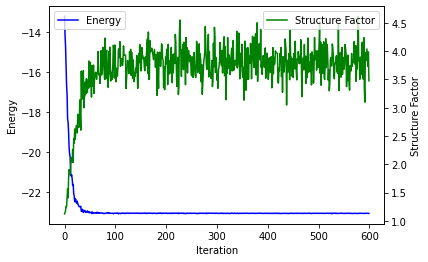

In [12]:
fig, ax1 = plt.subplots()
ax1.plot(iters, energy, color="blue", label="Energy")
ax1.set_ylabel("Energy")
ax1.set_xlabel("Iteration")
ax2 = ax1.twinx()
ax2.plot(iters, np.array(sf), color="green", label="Structure Factor")
ax2.set_ylabel("Structure Factor")
ax1.legend(loc=2)
ax2.legend(loc=1)
plt.show()

Let's also compute the average of those quantities (energy and neel order) over the last 50 iterations where the optimization seems to have converged.

In [13]:
print(
    rf"Structure factor = {np.mean(sf[-50:]):.3f}({np.std(np.array(sf[-50:]))/np.sqrt(50):.3f})"
)
print(
    rf"Energy = {np.mean(energy[-50:]):.3f}({np.std(energy[-50:])/(np.sqrt(50)):.3f})"
)

Structure factor = 3.797(0.039)
Energy = -23.062(0.001)


## 6) Sanity Check: Exact Diagonalisation

Now that we have obtained some results using VMC, it is a good time to check the quality of our results (at least for small system sizes). For this purpose, Netket provides exact diagonalisation tools.

In [14]:
E_gs, ket_gs = nk.exact.lanczos_ed(op, compute_eigenvectors=True)
structure_factor_gs = (
    ket_gs.T.conj() @ structure_factor.to_linear_operator() @ ket_gs
).real[0, 0]

Here we have specified that we want the corresponding eigenvector (in order to compute observables).

In [15]:
print(f"Exact Ground-state Structure Factor: {structure_factor_gs:.3f}")
print(f"Exact ground state energy = {E_gs[0]:.3f}")

Exact Ground-state Structure Factor: 3.803
Exact ground state energy = -23.064


So we see that the both energy and the structure factor we obtained is in agreement with the value obtained via exact diagonalisation.